In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict

import pandas as pd

import pickle

In [2]:
## CIFAR-100

MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [3]:
# ## CIFAR-10

# MODEL_FOLDER = 'cifar10/models'
# LIKELIHOOD = 'softmax'
# EPOCH = "049"

# logits, targets, ARGS = get_logits_targets('cifar10', MODEL_FOLDER, LIKELIHOOD, EPOCH)

In [4]:
# ## ImageNet

# with open(f'output/ImageNet.p', 'rb') as f:
#     data = pickle.load(f)
# logits, targets, ARGS = data

In [5]:
L = len(logits)
N = len(targets)

## 1 Ablations

In [6]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [7]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [8]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [9]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]

In [10]:
probs_ovr = ovr_likelihood(logits)
probs_moe_ovr = probs_ovr.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
preds_moe_ovr = {i: torch.argmax(probs_moe_ovr, dim=2)[i, :] for i in range(L)}
acc_moe_ovr = [(targets == preds_moe_ovr[i]).sum() / len(targets) for i in range(L)]

In [11]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]

In [12]:
probs_ovr_break_ties = torch.tensor(f_probs_ovr_logits_weighted(logits))
preds_ovr_break_ties = {i: torch.argmax(probs_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_ovr_break_ties = [(targets == preds_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [13]:
probs_ovr_break_ties = torch.tensor(f_probs_ovr_logits_weighted(logits))
probs_moe_ovr_break_ties = probs_ovr_break_ties.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
preds_moe_ovr_break_ties = {i: torch.argmax(probs_moe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_moe_ovr_break_ties = [(targets == preds_moe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [14]:
T = 1.
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [15]:
probs_poe_ovr_break_ties_softmax = torch.tensor(f_probs_ovr_poe_logits_softmax(logits, L=L))
preds_poe_ovr_break_ties_softmax = {i: torch.argmax(probs_poe_ovr_break_ties_softmax, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_softmax = [(targets == preds_poe_ovr_break_ties_softmax[i]).sum() / len(targets) for i in range(L)]

In [16]:
THRESHOLDS_MONOTONE = [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]

df_accuracy = pd.DataFrame(columns=[l for l in range(1, L+1)])
df_monotone = pd.DataFrame(columns=THRESHOLDS_MONOTONE)
df_monotone_rel = pd.DataFrame(columns=THRESHOLDS_MONOTONE)
for likelihood, ensemble_type, _acc, _probs, _preds in [("softmax", "/", acc, probs, preds),
                                                        ("softmax", "MoE", acc_de, probs_de, preds_de),
                                                        ("softmax", "PoE", acc_poe, probs_poe, preds_poe),
                                                        ("hard OvR", "/", acc_ovr, probs_ovr, preds_ovr),
                                                        ("hard OvR", "MoE", acc_moe_ovr, probs_moe_ovr, preds_moe_ovr),
                                                        ("hard OvR", "PoE", acc_poe_ovr, probs_poe_ovr, preds_poe_ovr),
                                                        ("tie-breaking OvR", "/", acc_ovr_break_ties, probs_ovr_break_ties, preds_ovr_break_ties),
                                                        ("tie-breaking OvR", "MoE", acc_moe_ovr_break_ties, probs_moe_ovr_break_ties, preds_moe_ovr_break_ties),
                                                        ("tie-breaking OvR", "PoE", acc_poe_ovr_break_ties, probs_poe_ovr_break_ties, preds_poe_ovr_break_ties),
                                                        ("softmax OvR", "PoE", acc_poe_ovr_break_ties_softmax, probs_poe_ovr_break_ties_softmax, preds_poe_ovr_break_ties_softmax)
                                                        ]:
    if _acc:
        df_accuracy.loc[f'{likelihood}+{ensemble_type}', :] = [round(float(x), 4) * 100 for x in _acc]
        df_monotone.loc[f'{likelihood}+{ensemble_type}', :] = [round(x, 4) for x in modal_probs_decreasing(_preds, _probs, L, N=N, thresholds=THRESHOLDS_MONOTONE, diffs_type="all").values()]
        df_monotone_rel.loc[f'{likelihood}+{ensemble_type}', :] = [round(x, 4) for x in modal_probs_decreasing_relative(_preds, _probs, L, N=N, thresholds=THRESHOLDS_MONOTONE, diffs_type="all").values()]

In [17]:
df_accuracy

,1,2,3,4,5,6,7
softmax+/,65.14,68.1,70.62,72.24,72.64,72.85,72.85
softmax+MoE,65.14,69.94,72.89,74.38,75.36,75.77,76.04
softmax+PoE,65.14,70.29,73.48,74.58,75.55,75.93,76.18
hard OvR+/,2.25,2.27,2.42,2.46,2.28,2.34,2.21
hard OvR+MoE,2.25,3.11,3.79,4.31,4.73,5.01,5.21
hard OvR+PoE,2.25,3.11,3.79,4.31,4.73,5.01,5.21
tie-breaking OvR+/,65.14,68.1,70.62,72.24,72.64,72.85,72.85
tie-breaking OvR+MoE,65.14,70.2,73.36,74.44,75.5,75.91,76.27
tie-breaking OvR+PoE,65.14,70.28,73.42,74.82,75.53,75.68,75.6
softmax OvR+PoE,65.14,70.29,73.48,74.58,75.55,75.93,76.18


In [18]:
for row in df_accuracy[[1, 2, L]].iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

softmax+/
65.14 & 68.10000000000001 & 72.85000000000001
softmax+MoE
65.14 & 69.94 & 76.03999999999999
softmax+PoE
65.14 & 70.28999999999999 & 76.18
hard OvR+/
2.25 & 2.27 & 2.21
hard OvR+MoE
2.25 & 3.11 & 5.21
hard OvR+PoE
2.25 & 3.11 & 5.21
tie-breaking OvR+/
65.14 & 68.10000000000001 & 72.85000000000001
tie-breaking OvR+MoE
65.14 & 70.19999999999999 & 76.27000000000001
tie-breaking OvR+PoE
65.14 & 70.28 & 75.6
softmax OvR+PoE
65.14 & 70.28999999999999 & 76.18


In [19]:
df_monotone

,-0.0001,-0.0100,-0.0500,-0.1000,-0.2000,-0.2500,-0.3300,-0.5000
softmax+/,86.54,67.38,56.27,49.78,41.72,38.16,32.92,23.15
softmax+MoE,67.78,53.95,41.11,30.51,17.33,12.63,7.78,1.68
softmax+PoE,64.16,44.08,31.15,22.29,12.31,8.85,5.18,1.22
hard OvR+/,92.46,40.53,0.0,0.0,0.0,0.0,0.0,0.0
hard OvR+MoE,84.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hard OvR+PoE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tie-breaking OvR+/,96.58,63.96,0.18,0.0,0.0,0.0,0.0,0.0
tie-breaking OvR+MoE,65.28,7.86,0.01,0.0,0.0,0.0,0.0,0.0
tie-breaking OvR+PoE,0.36,0.12,0.0,0.0,0.0,0.0,0.0,0.0
softmax OvR+PoE,64.15,44.08,31.11,22.3,12.25,8.82,5.18,1.22


In [20]:
for row in df_monotone[[-0.01, -0.1, -0.25]].iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

softmax+/
67.38 & 49.78 & 38.16
softmax+MoE
53.95 & 30.51 & 12.63
softmax+PoE
44.08 & 22.29 & 8.85
hard OvR+/
40.53 & 0.0 & 0.0
hard OvR+MoE
0.0 & 0.0 & 0.0
hard OvR+PoE
0.0 & 0.0 & 0.0
tie-breaking OvR+/
63.96 & 0.0 & 0.0
tie-breaking OvR+MoE
7.86 & 0.0 & 0.0
tie-breaking OvR+PoE
0.12 & 0.0 & 0.0
softmax OvR+PoE
44.08 & 22.3 & 8.82


In [21]:
df_monotone_rel

,-0.0001,-0.0100,-0.0500,-0.1000,-0.2000,-0.2500,-0.3300,-0.5000
softmax+/,86.58,68.74,59.71,55.19,50.15,48.12,45.09,39.31
softmax+MoE,67.81,55.37,47.34,41.59,31.11,26.41,18.9,4.73
softmax+PoE,64.18,45.14,34.82,28.46,20.24,16.75,12.52,5.77
hard OvR+/,92.46,92.46,85.92,69.31,42.7,40.74,40.53,40.53
hard OvR+MoE,92.54,72.72,16.75,2.11,0.01,0.0,0.0,0.0
hard OvR+PoE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tie-breaking OvR+/,96.73,95.0,84.92,64.69,28.34,17.25,7.87,1.44
tie-breaking OvR+MoE,66.43,55.75,27.34,11.76,2.03,0.76,0.14,0.0
tie-breaking OvR+PoE,0.37,0.33,0.12,0.03,0.0,0.0,0.0,0.0
softmax OvR+PoE,64.16,45.12,34.8,28.45,20.22,16.7,12.48,5.75


In [22]:
for row in df_monotone_rel[[-0.01, -0.1, -0.25]].iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

softmax+/
68.74 & 55.19 & 48.12
softmax+MoE
55.37 & 41.59 & 26.41
softmax+PoE
45.14 & 28.46 & 16.75
hard OvR+/
92.46 & 69.31 & 40.74
hard OvR+MoE
72.72 & 2.11 & 0.0
hard OvR+PoE
0.0 & 0.0 & 0.0
tie-breaking OvR+/
95.0 & 64.69 & 17.25
tie-breaking OvR+MoE
55.75 & 11.76 & 0.76
tie-breaking OvR+PoE
0.33 & 0.03 & 0.0
softmax OvR+PoE
45.12 & 28.45 & 16.7


In [23]:
import matplotlib
# import Line2D for custom legends
from matplotlib.lines import Line2D
 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1, dpi=dpi, autolayout=True)  # fontsize of the figure 
matplotlib.rc('lines', linewidth=1, markersize=3)
matplotlib.rc('savefig', dpi=1200, bbox='tight')
matplotlib.rc('grid', alpha=0.3)
matplotlib.rc('axes', grid=True)
# remove marker edges
# matplotlib.rc('lines', markeredgewidth=0)

matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

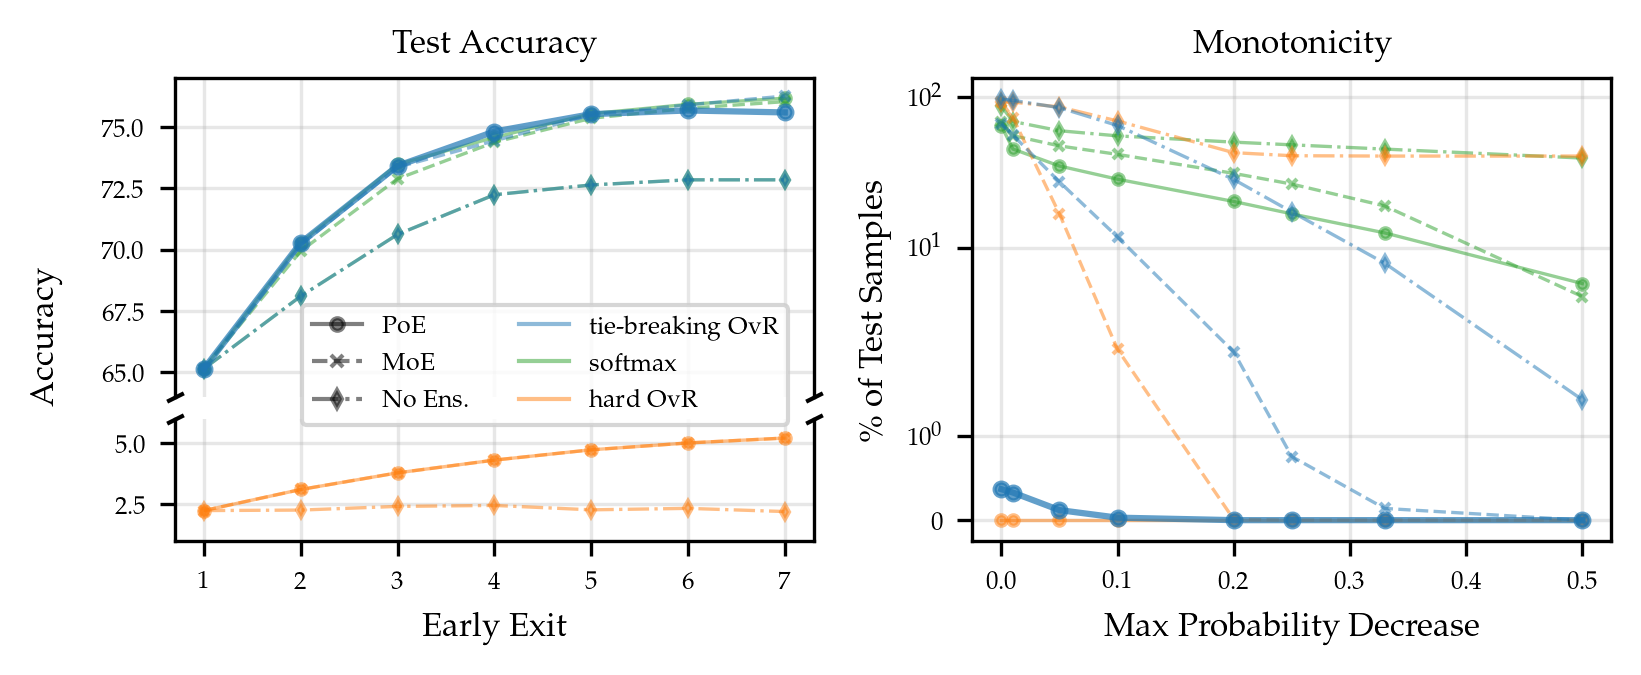

In [34]:
fig = plt.figure(figsize=(text_width, text_width * 5/12))
gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig)
gs0 = gs[0].subgridspec(2, 1, hspace=0.1, height_ratios=[77-64, 6-1])

colors = {'softmax': 'tab:green', 'hard OvR': 'tab:orange', 'tie-breaking OvR': 'tab:blue'}
line_styles = {'/': '-.', 'MoE': '--', 'PoE': '-'}
marker_styles = {'PoE': 'o', 'MoE': 'x', '/': 's'}

ax = [fig.add_subplot(gs0[0]), fig.add_subplot(gs0[1]), fig.add_subplot(gs[:, 1])]

ours_kwargs = {'lw': 1.5, 'ms':3.3, 'alpha':0.7}
default_kwargs = {'lw': 0.8, 'ms':2.5, 'alpha':0.5}

# Create the accuracy plot
for name, accs in df_accuracy.iterrows():
    likelihood, ensemble_type = name.split('+')
    if likelihood == 'softmax OvR':
        continue
    if ensemble_type == 'PoE' and likelihood == 'tie-breaking OvR':
        kwargs = ours_kwargs
    else:
        kwargs = default_kwargs
    ax[0].plot(list(df_accuracy.columns), accs, marker=marker_styles[ensemble_type], label=name, color=colors[likelihood], ls=line_styles[ensemble_type], **kwargs)

# ax[0].set_xlabel('Early Exit')
# ax[0].set_ylabel('Accuracy')
ax[0].set_title('Test Accuracy')
# set log scale
# ax[0].set_yscale('symlog')
# ax[0].set_yticks([1, 3, 10, 10, 100])
ax[0].set_ylim([64, 77])


for name, accs in df_accuracy.iterrows():
    likelihood, ensemble_type = name.split('+')
    if likelihood == 'softmax OvR':
        continue
    if ensemble_type == 'PoE' and likelihood == 'tie-breaking OvR':
        kwargs = ours_kwargs
    else:
        kwargs = default_kwargs
    ax[1].plot(list(df_accuracy.columns), accs, marker=marker_styles[ensemble_type], label=name, color=colors[likelihood], ls=line_styles[ensemble_type], **kwargs)

ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel('Accuracy')
# ax[1].set_title('Test Accuracy')
# set log scale
# ax[1].set_yscale('symlog')
# ax[1].set_yticks([1, 3, 10, 10, 100])
ax[1].set_ylim([1, 6])

fig.supylabel('Accuracy', fontsize=fs)
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].tick_params(axis='x', which='both',length=0, labelbottom=False)
# ax[0].xaxis.no_ticks()
# ax[0].tick_params(labeltop=False)  # don't put tick labels at the top
ax[1].xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=4,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)



# create the relative monotonicity plot
for name, drops in df_monotone_rel.iterrows():
    likelihood, ensemble_type = name.split('+')
    if likelihood == 'softmax OvR':
        continue
    if ensemble_type == 'PoE' and likelihood == 'tie-breaking OvR':
        kwargs = ours_kwargs
    else:
        kwargs = default_kwargs
    ax[2].plot(-1 * np.array(df_monotone_rel.columns), drops, marker=marker_styles[ensemble_type], label=name, color=colors[likelihood], ls=line_styles[ensemble_type], **kwargs)

ax[2].set_xlabel('Max Probability Decrease')
ax[2].set_ylabel('\% of Test Samples')
ax[2].set_title('Monotonicity')
ax[2].set_yscale('symlog')
# ax[1].set_xticks(-1 * np.array(df_monotone_rel.columns))


lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='-.', marker='s', alpha=0.5),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.5),
]
labels = [
    "PoE",
    "MoE",
    "No Ens.",
    "ReLU",
    "softmax",
    "Heaviside",
]
ax[1].legend(lines, labels, ncol=2, bbox_to_anchor=(0.18, .85), loc='lower left')

plt.tight_layout()
plt.savefig(f'figures/figure_ablation.pdf', dpi=1200, bbox_inches='tight')
plt.show()

## 2 Why MoE-OvR is not muy bien

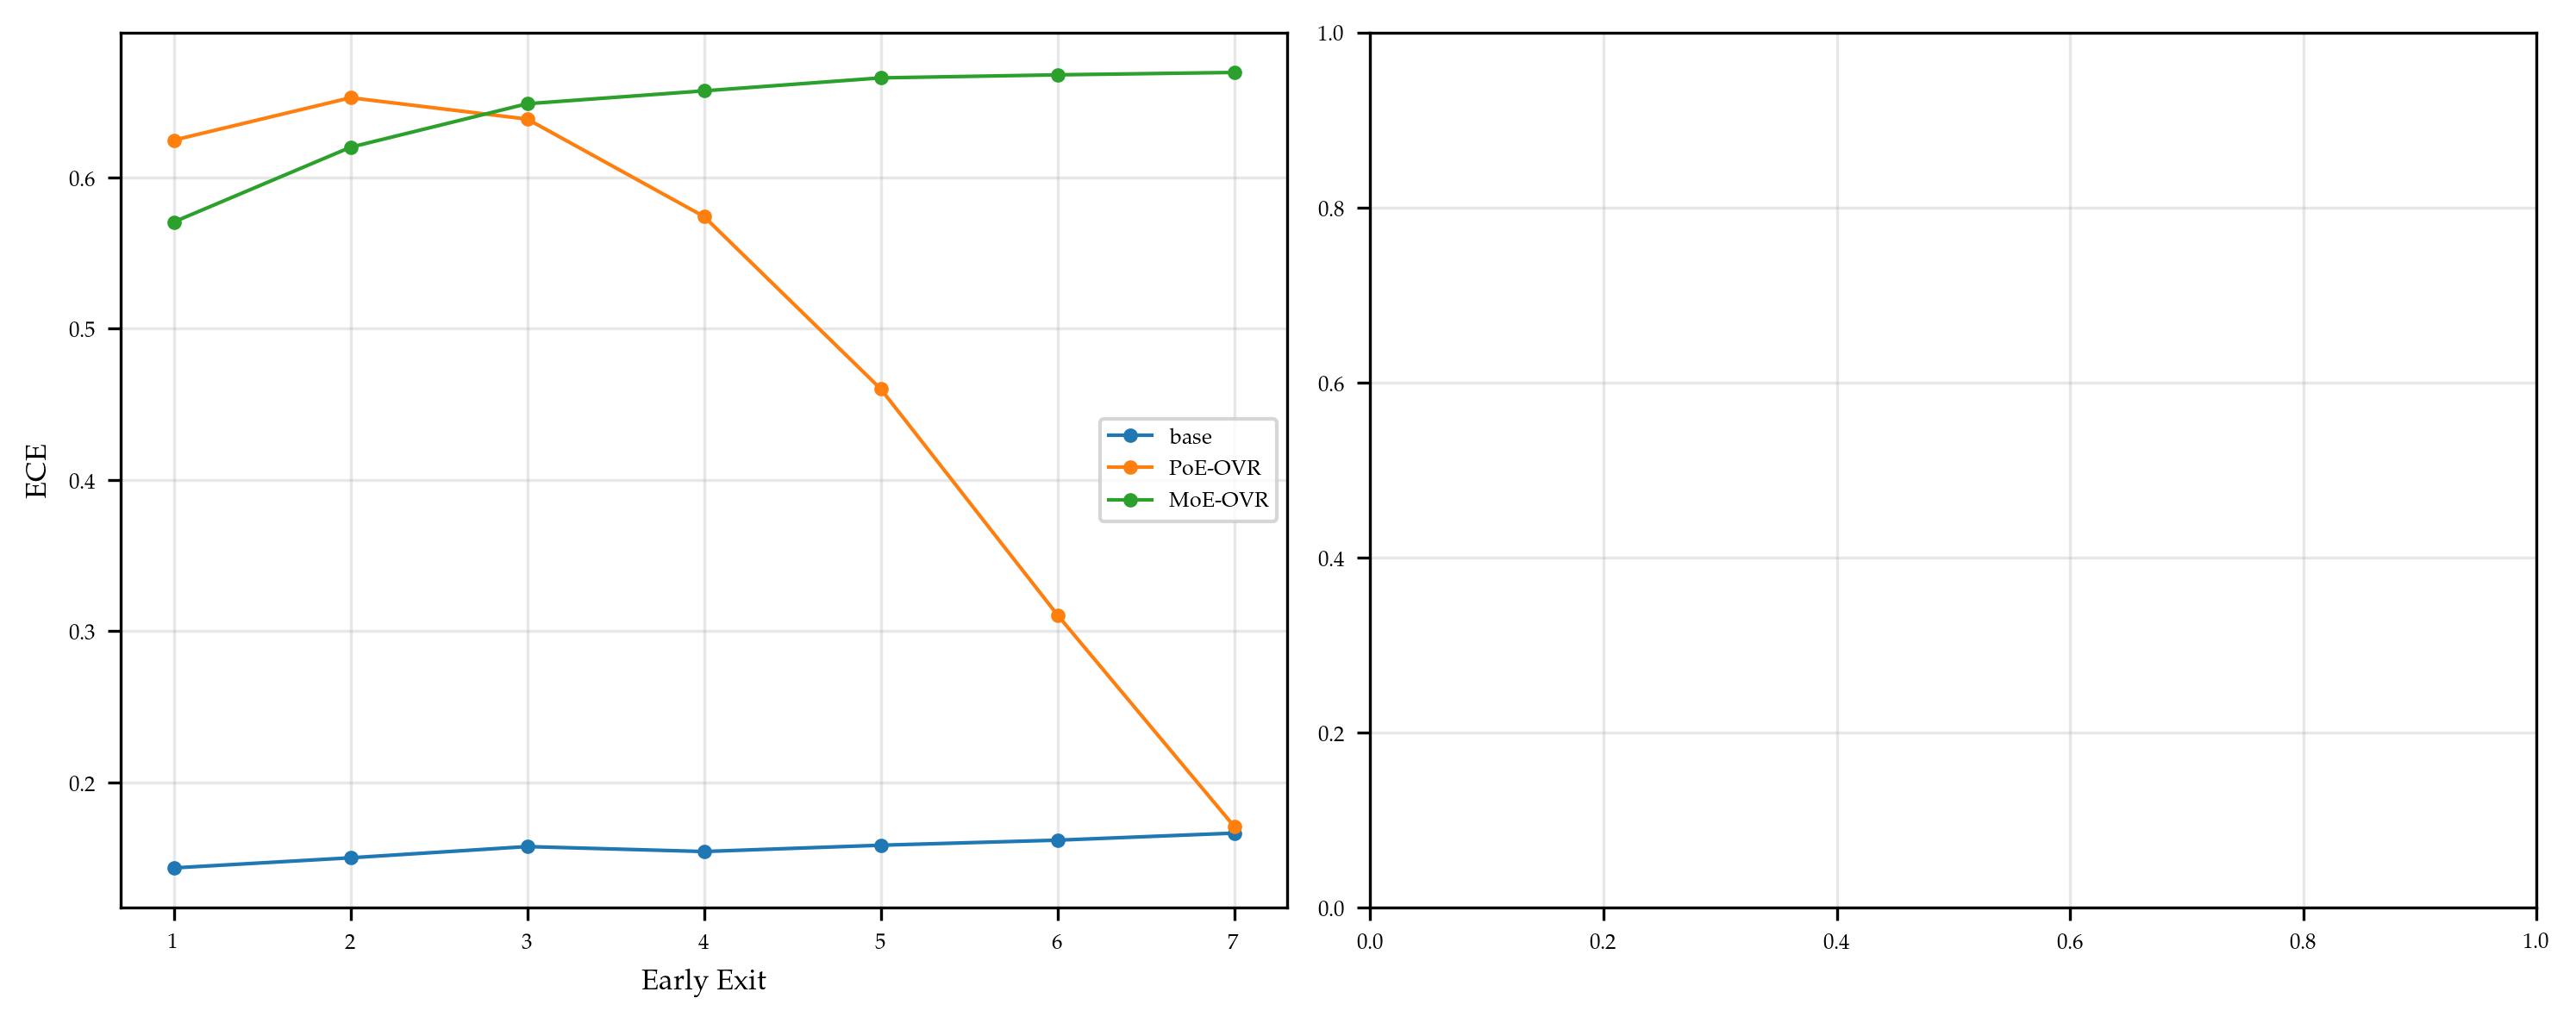

In [25]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for _probs, label in zip([probs, probs_poe_ovr_break_ties, probs_moe_ovr_break_ties], ['base', 'PoE-OVR', 'MoE-OVR']):
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(list(range(1, L + 1)), ece, marker='o', label=label)
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('ECE')
ax[0].legend()

plt.tight_layout()
# plt.savefig(f'figures/figure_4.pdf', dpi=1200)
plt.show()

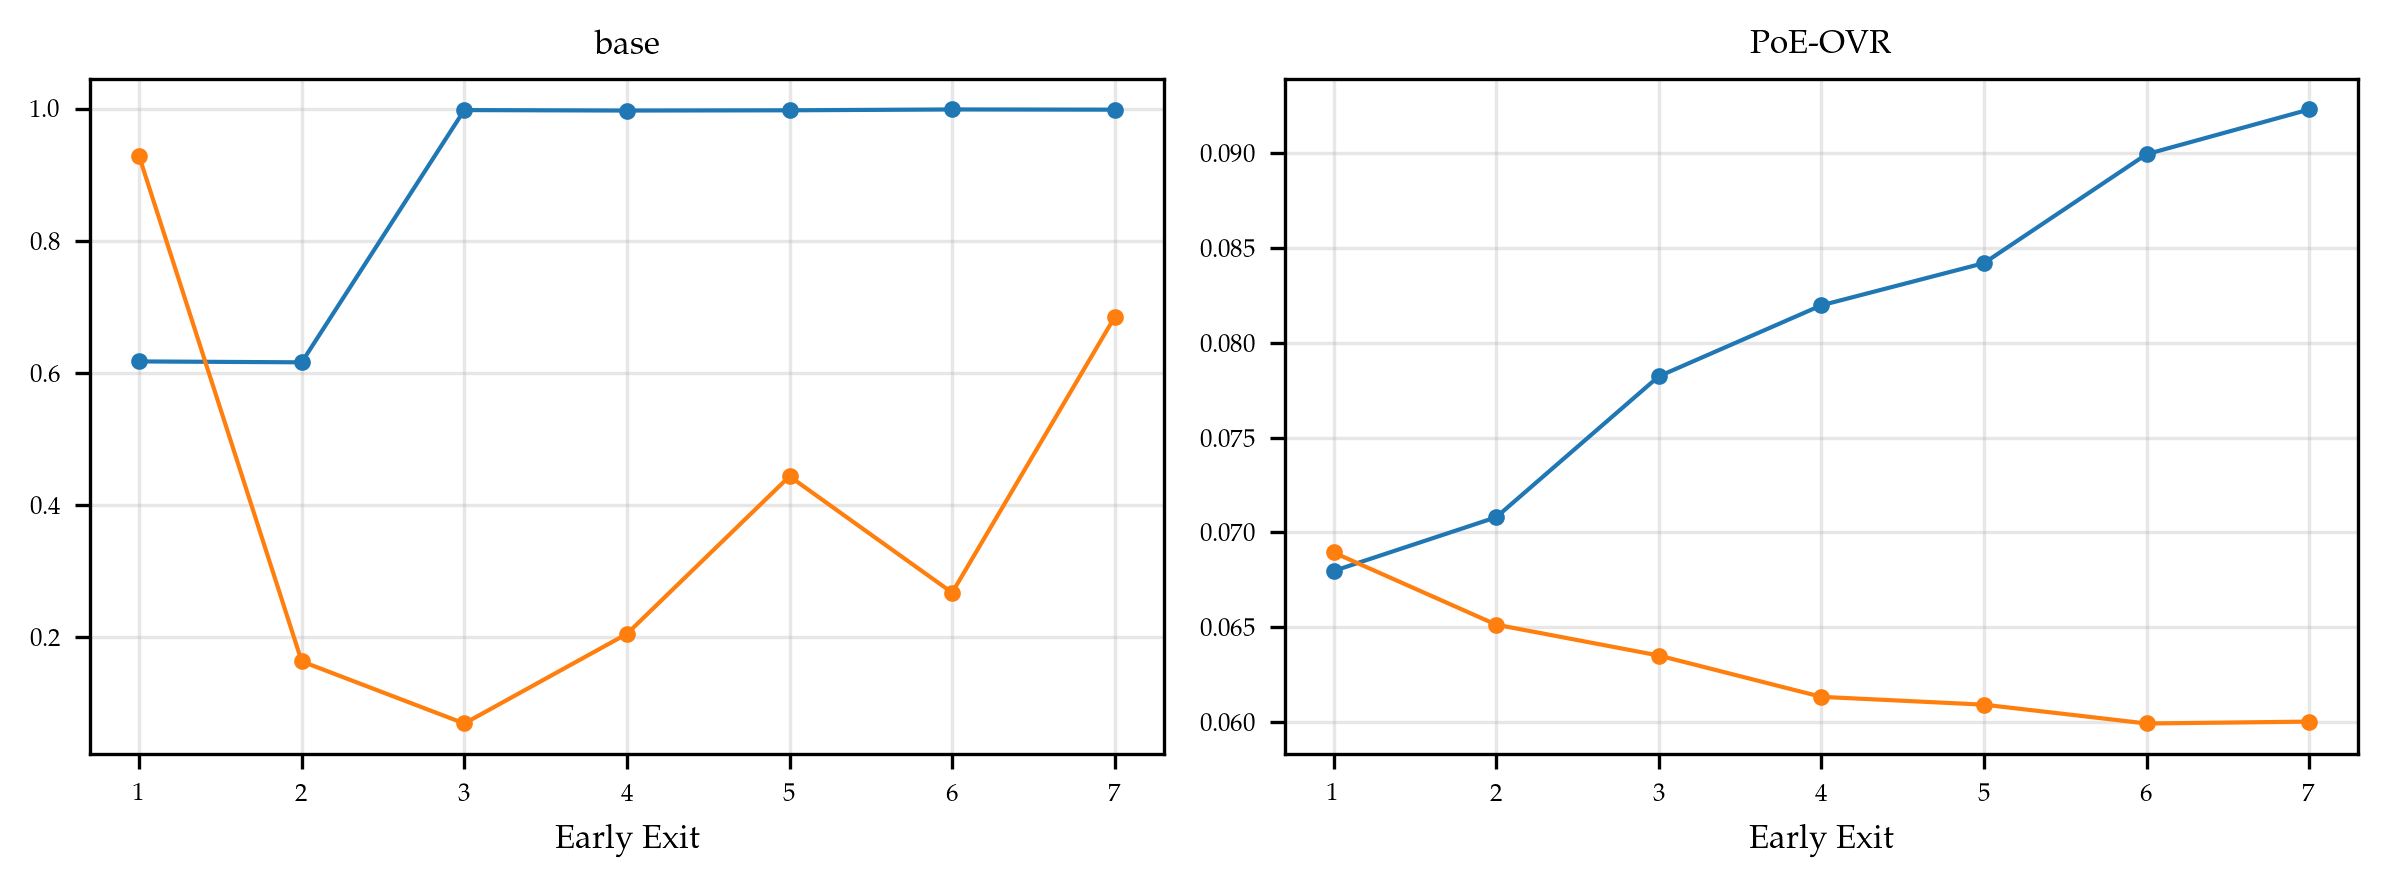

In [26]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
early_exits = [i + 1 for i in range(L)]

ax[0].set_xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[0].set_xticks(early_exits)
ax[0].set_title('base')


ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        # probs_i = probs_poe_ovr_break_ties[:, i, preds_poe_ovr_break_ties[L - 1][i]].cpu()
        probs_i = probs_moe_ovr_break_ties[:, i, preds_moe_ovr_break_ties[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)
ax[1].set_title('PoE-OVR')

# plt.savefig(f'figures/figure_3_{PLOT_TYPE}.pdf', dpi=1200)
plt.show()